<a href="https://colab.research.google.com/github/SandeshBashyal/naamii_labs_2023/blob/main/Lab_7_exercise_Fundamentals_of_GNN_(LAB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors:

*Federico Barbero federico.barbero@cs.ox.ac.uk*, *Ben Finkelshtein ben.finkelshtein@kellogg.ox.ac.uk*, *Haitz Sáez de Ocáriz Borde haitz@oxfordrobotics.institute*  


Based off of a notebook by *Pim de Haan* and *Nikola Jovanović*.

# Welcome to the first Geometric Deep Learning pratical 😀 
This is the first practical on the *Fundamentals of GNNs*. In this pratical, you will learn all about the basics of Geometric Deep Learning and Graph Neural Networks. It will be great fun!


## Instructions

**Outline**
- [Warmup] The Geometric Deep Learning Blueprint
- [Introduction] Graphs, networkx
- [Basic Models] Implementing GCN and GAT
- [PyTorch Geometric] Use Pytorch Geometric for Graph Classification

Instructions:
- Make a copy of this notebook.
- Make sure the GPU is turned on. Runtime -> Change runtime type -> Hardware accelereator -> GPU
- Fill in your solutions between `### BEGIN SOLUTION` and `### END SOLUTION`. Do not create additional cells.
- Your code should run without errors in Google Colab.
- You are not allowed to use layers from Pytorch Geometric (nor any other graph library) in your models. Just use basic pytorch, except for the two functions mentioned in the GAT model. Of course, you are allowed to use PyTorch Geometric in the final PyTorch geometric section.
- For your solution to be correct, you should achieve at least the task accuracy as stated in the tasks (although some unlucky seeds may give you slightly lower accuracy).

Have fun!

Our very cool demonstrator Federico (Federico definitely did not write this) made some supplementary YouTube videos for the practical, feel free to check them out if you feel a bit lost or would like a refresher :)

In [13]:
#@title
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/CwHNUX2GWvE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [14]:
#@title
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/iAEDA8aDCZg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

In [15]:
#@title
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/qAF3ZHmkXUw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

## [Warmup] The Geometric Deep Learning Blueprint

The Geometric Deep Learning (GDL) Blueprint gives us some sort of recipe for building powerful Deep Learning models from first principles. The two main building blocks are the equivariant layers and the invariant layer at the end. Optionally, one can also introduce pooling layers between the equivariant layer.


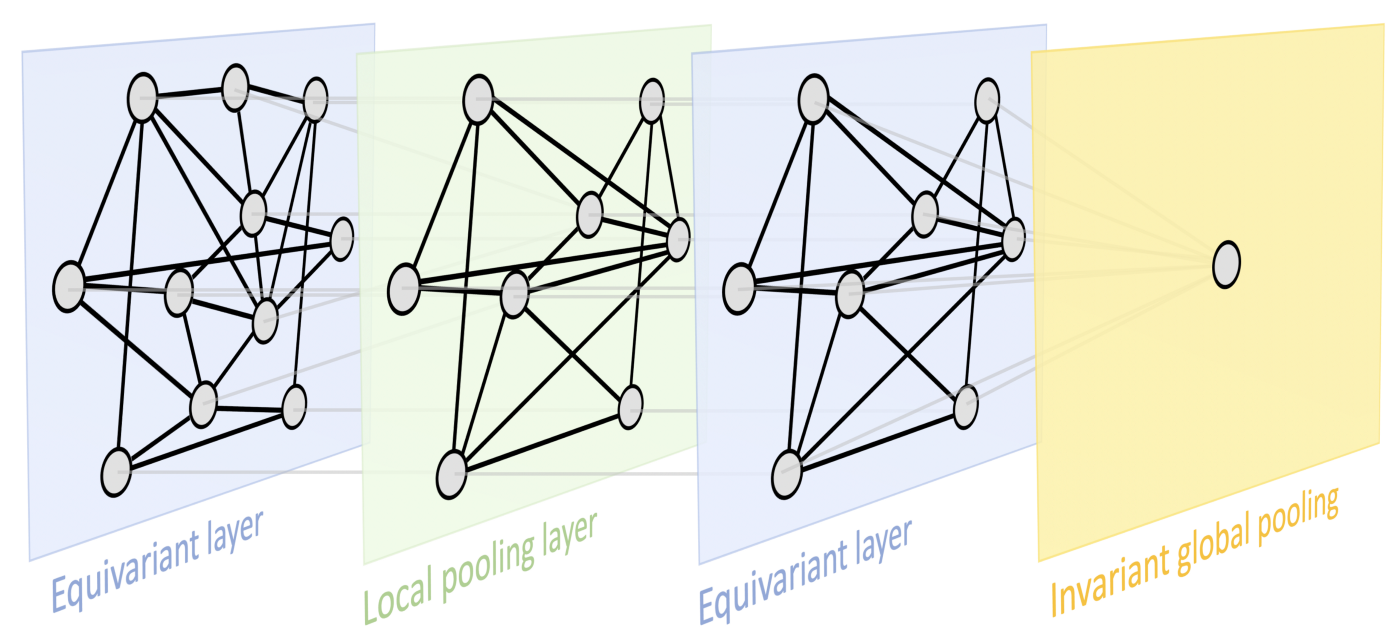

### ***Task 1: GDL Blueprint***
Write a paragraph commenting on the GDL Blueprint. Consider the following questions: 

*   What is the purpose of each component?
*   Why do we use the invariant layer only at the end? - What would happen if the invariant layer was placed at the start?
*   Why may we need multiple equivariant layers - possibly interleaved with pooling layers?



Answer here...

1 Ans:

## [Introduction] Graphs, networkx

### Recap of graph fundamentals

A **graph** is a pair $\mathcal{G} = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of $N$ **vertices** (nodes), and $\mathcal{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathcal{V}$. We will here consider **undirected** graphs, meaning that $(u,v) \in \mathcal{E} \implies (v,u) \in \mathcal{E}$.

There are two common ways to represent $\mathcal{E}$: 
1. As an **adjacency matrix**: a binary square matrix $A$ of size $N \times N$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
2. As an **adjacency list**: a list of ordered pairs $(u,v)$.


### NetworkX





NetworkX is a Python library focused on graphs and networks, offering a large number of useful methods, including visualization which we will use several times in this colab.

Let's install the library and proceed to create and draw a simple graph:

In [1]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ***Task 2: Graph definition***
The first task is to recreate the graph below using Networkx. Fill in you solution between `### BEGIN SOLUTION` and `### END SOLUTION`. Note that the position of the node in the graph you plot may differ from this image. What matters is that the same nodes are connected.**bold text**

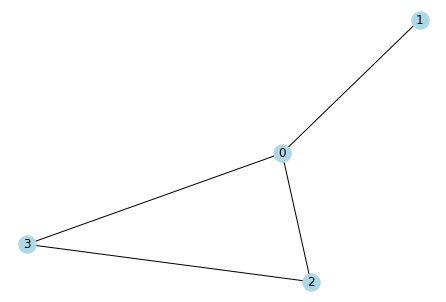

Graph G with 4 nodes and 4 edges
Adjacency list: [(0, 1), (0, 2), (0, 3), (2, 3)]
Adjacency matrix (symmetric):
[[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]
Degree of node 1: 1


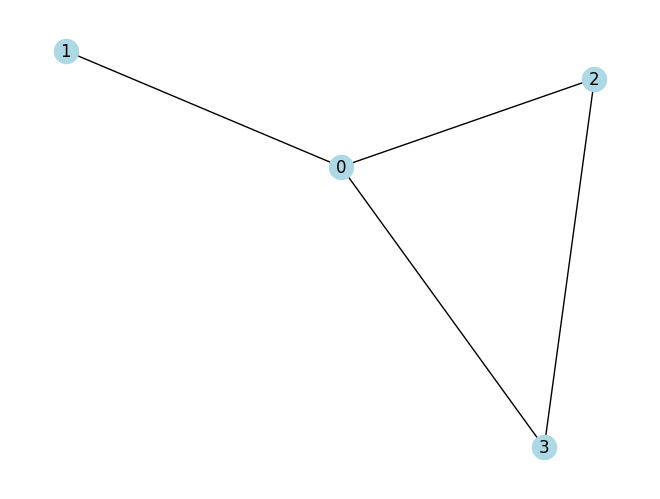

In [3]:
import networkx as nx 

# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs

### BEGIN SOLUTION
G.add_nodes_from([0, 1, 2, 3]) # Fill in the list of node labels as integers
G.add_edges_from([(0, 1), (0, 2), (2, 3), (0, 3)]) # Fill in the list of node pairs [(node_a, node_b)]
# Note that for a NetworkX (undirected) Graph, you do not need to provide both (node_a, node_b) and (node_b, node_a)
## END SOLUTION

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 1: {G.degree(1)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

## [Part 1] Implementing GCN and GAT

Recall the high-level perspective on the way GNNs are applied:



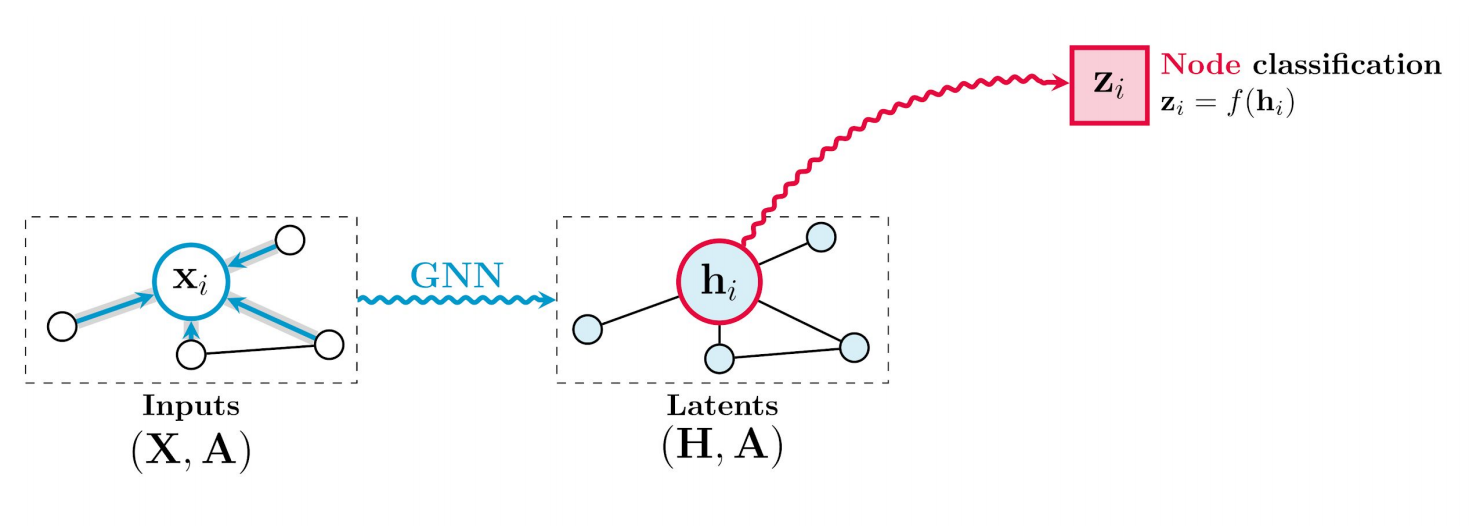

We start from a graph with adjacency matrix $A$ and node features $x_i$. Using a GNN, for each node we compute (based on its neighborhood) a latent feature vector $h_i$. With these we can attempt to solve various tasks, where for now we focus on **node classification** (the other two common tasks will be shown in Part 2 of this tutorial).

In node classification, we are most often given a single graph, where only a portion of nodes is labeled. Using these nodes as a signal for training, our goal is to successfully classify the remaining nodes. To this end, we look at previously computed node latent vectors in isolation, and learn a classifier $z_i = f(h_i)$.




### Cora dataset


For this problem we will use **Cora**, a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. The goal is to classify each paper into one of seven classes (topics).

We will load and inspect the Cora dataset using the PyTorch Geometric library (which we will use again in Part 2):

In [4]:
import torch
torch.__version__ 

# If you are having issues importing the packages below
# check that the cuda/pytorch versions match

# It may ask you to restart the runtime with the command below

'2.0.1+cu118'

In [8]:
# -f https://data.pyg.org/whl/torch-2.0.0+cu118.html     -2.0.1 --> version
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 67.5 MB/s eta 0:00:00
  Using cached torch_geometric-2.3.1.tar.gz (661 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=ca1027dfb2a14203964a0e1b170a6322e7b7bf43e1aae9b6dca2489cfb01e237
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [9]:
import torch_geometric
from torch_geometric.utils import to_dense_adj

# Fetch the Dataset object
dataset = torch_geometric.datasets.Planetoid(root='~/', name='Cora')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()

# One graph is one Data object, with the following attributes:
#   edge_index:     the adjacency list of shape [2, num_edges] (COO format)
#   x:              the feature matrix of shape [num_nodes, num_features]
#   y:              node labels of shape [num_nodes]
#   train_mask:     a boolean mask of shape [num_nodes], indicating the train set
#                   (similarly for val_mask and test_mask)
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print()

print('Train mask:')
print(data.train_mask)
print('Edge index:')
print(data.edge_index)
print('Corresponding adjacency matrix (using to_dense_adj):')
print(to_dense_adj(data.edge_index))
print()

# Some more utility functions on a Data object 
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!


Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000

Train mask:
tensor([ True,  True,  True,  ..., False, False, False])
Edge index:
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
Corresponding adjacency matrix (using to_dense_adj):
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]]])

Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


*Note*: The Cora dataset (similarly for MUTAG which we will use later) is great for rapid prototyping and sanity-checking of models. However, it is widely considered to be oversaturated, and it is advised to use higher quality datasets (such as [OGB](https://ogb.stanford.edu/) or [benchmarking-gnns](https://github.com/graphdeeplearning/benchmarking-gnns)) whenever possible.


### Building a simple graph neural network.

Recall that $\mathbf{A}$ is the adjacency matrix and $\mathbf{D}$ is the diagonal matrix of node degrees. We have three models:

1.   $\text{GCN}_{RW} = \sigma(\mathbf{D}^{-1}\mathbf{AHW}) $
2.   $\text{GCN} = \sigma(\mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2}\mathbf{HW}) $
3.   $\text{GAT}$ 


With our dataset ready, we can start working on our model. In all the examples in this section we will use the same 2-layer network. 

Given as inputs $A$, the $N \times N$ adjacency matrix, and $H$, the $N \times F$ feature matrix, where each node has an $F$-dimensional feature vector, the propagation rule of mean-pool is as follows:
$$ H' = \sigma(D^{-1}AHW^T) $$
Here, $W$ is a learnable weight matrix of shape $F' \times F$, $D$ is the diagonal matrices containing the degree of the nodes, $\sigma(\cdot)$ is a non-linear activation function (e.g. ReLU), and H' holds the output node features ($N \times F'$).

Focusing on node $i$, we get the following equation for its features (where $\mathcal{N}(i)$ is the set of its neighbors):
$$ h'_i = \sigma \left( \frac{1}{\mathcal{N}(i)}\sum_{j \in \mathcal{N}(i)}  Wh_j \right) $$

In other words, we simply average the transformed features of all neighbors. Let's implement this layer in a class extending `torch.nn.Module`.

*Note*: we assume that $A$ was preprocessed to contain all self-edges (as otherwise a node would not depend on its own features which is clearly undesirable).

$A = A^* + I$ 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

In [11]:
# We will use the following code to run our implementation:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the given model on the given graph for num_epochs
def train(model, data, num_epochs, use_edge_index=False):
    data.x = data.x.to(device)
    data.y = data.y.to(device)
    data.edge_index = data.edge_index.to(device)

    if not use_edge_index: 
        # Create the adjacency matrix
        # Important: add self-edges so a node depends on itself
        adj = to_dense_adj(data.edge_index)[0]
        adj += torch.eye(adj.shape[0], device=device)
    else:
        # Directly use edge_index, ignore this branch for now
        adj = data.edge_index

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # A utility function to compute the accuracy
    def get_acc(outs, y, mask):
        return (outs[mask].argmax(dim=1) == y[mask]).sum().float() / mask.sum()

    best_acc_val = -1
    for epoch in range(num_epochs):
        # Zero grads -> forward pass -> compute loss -> backprop
        optimizer.zero_grad()
        outs = model(data.x, adj)
        loss = loss_fn(outs[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute accuracies, print only if this is the best result so far
        acc_val = get_acc(outs, data.y, data.val_mask)
        acc_test = get_acc(outs, data.y, data.test_mask)
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Val: {acc_val:.3f} | Test: {acc_test:.3f}')
    
    print('Done')

### MLP baseline
First, let us make a simple MLP baseline and evaluate it using the `train` function. It should achieve at least 51% test accuracy.

In [12]:
class MLPModel(nn.Module):
    def __init__(self, num_layers=2, sz_in=1433, sz_hid=32, sz_out=7):
        super().__init__()

        self.layers = nn.ModuleList([nn.Linear(
            sz_in if i == 0 else sz_hid,
            sz_out if i == num_layers-1 else sz_hid,
            )
            for i in range(num_layers)
        ])

    def forward(self, fts, adj):
        """
        Args:
            fts: [N, 1433]
            adj: [N, N] - ignore this argument for this baseline.

        Returns:
            new_fts: [N, 7]
        """
        for i, layer in enumerate(self.layers):
            fts = layer(fts)
            if i < len(self.layers)-1:
                fts = torch.relu(fts)

        return fts

train(MLPModel().to(device), data, num_epochs=100)

[Epoch 1/100] Loss: 1.952215552330017 | Val: 0.230 | Test: 0.218
[Epoch 2/100] Loss: 1.8511801958084106 | Val: 0.328 | Test: 0.303
[Epoch 3/100] Loss: 1.7181845903396606 | Val: 0.374 | Test: 0.357
[Epoch 4/100] Loss: 1.5461140871047974 | Val: 0.440 | Test: 0.413
[Epoch 5/100] Loss: 1.346073865890503 | Val: 0.494 | Test: 0.476
[Epoch 6/100] Loss: 1.1318931579589844 | Val: 0.540 | Test: 0.521
[Epoch 7/100] Loss: 0.9187722206115723 | Val: 0.568 | Test: 0.538
[Epoch 10/100] Loss: 0.40858468413352966 | Val: 0.570 | Test: 0.555
Done


### ***Task 3: Implement GNN***
Now, let's implement the graph neural network we introduced above with mean aggregation. You should expect at least 79% test accuracy.

In [17]:
class GNNModel(nn.Module):
    def __init__(self, num_layers=2, sz_in=1433, sz_hid=32, sz_out=7):
        super().__init__()

        ### BEGIN SOLUTION
        if num_layers != 2:
          raise "Not implemented!"

        self.W1 = nn.Linear(in_features = sz_in, out_features = sz_hid, bias = True)
        self.W2 = nn.Linear(in_features = sz_hid, out_features = sz_out, bias = True)
        ### END SOLUTION

    def forward(self, fts, adj):
        """
        Args:
            fts: [N, 1433]
            adj: [N, N]

        Returns:
            new_fts: [N, 7]
        """
        deg = adj.sum(axis=1, keepdim=True) # Degree of nodes, shape [N, 1]
        
        ### BEGIN SOLUTION
        dinv_a = adj / deg
        hw1 = self.W1(fts)
        fts_2 = F.relu(torch.mm(dinv_a, hw1))
        hw2 = self.W2(fts_2)
        fts_final = torch.mm(dinv_a, hw2)
        ### END SOLUTION
        return fts_final

train(GNNModel().to(device), data, num_epochs=100)

[Epoch 1/100] Loss: 1.9492971897125244 | Val: 0.168 | Test: 0.157
[Epoch 2/100] Loss: 1.8611589670181274 | Val: 0.438 | Test: 0.446
[Epoch 3/100] Loss: 1.7326992750167847 | Val: 0.664 | Test: 0.691
[Epoch 4/100] Loss: 1.588098168373108 | Val: 0.674 | Test: 0.699
[Epoch 6/100] Loss: 1.2735118865966797 | Val: 0.688 | Test: 0.716
[Epoch 7/100] Loss: 1.1046297550201416 | Val: 0.716 | Test: 0.740
[Epoch 8/100] Loss: 0.9379503726959229 | Val: 0.746 | Test: 0.760
[Epoch 9/100] Loss: 0.7804254293441772 | Val: 0.750 | Test: 0.771
[Epoch 10/100] Loss: 0.6370688080787659 | Val: 0.778 | Test: 0.791
[Epoch 11/100] Loss: 0.5108695030212402 | Val: 0.802 | Test: 0.797
Done


### Task 4: Adjacencies! 😎   
As you know by now, the structure of the adjacency matrix is very important to solve the task at hand. So let's consider some edges cases, namely $\mathbf{A} = \mathbf{I}$ (diagonal) and $\mathbf{A} = \mathbf{1}\mathbf{1}^T$ (fully connected).

Answer (briefly) the following questions:

1.   What do the graphs look like for each special adjacency matrix?
2.   What does a GNN (in the form we have seen) with a diagonal adjacency matrix collapse to?
3.   What problems may arise with having a fully connected adjacency matrix regarding computational complexity and, more importantly, the representations? Why is a fully connected adjacency matrix especially problematic for GCN but not GAT?

*(Bonus)* If you want to make us happy feel free to evaluate the GNN model with these adjacency matrices.

Graph G with 5 nodes and 5 edges
Graph G with 5 nodes and 25 edges


(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]),
 None,
 None)

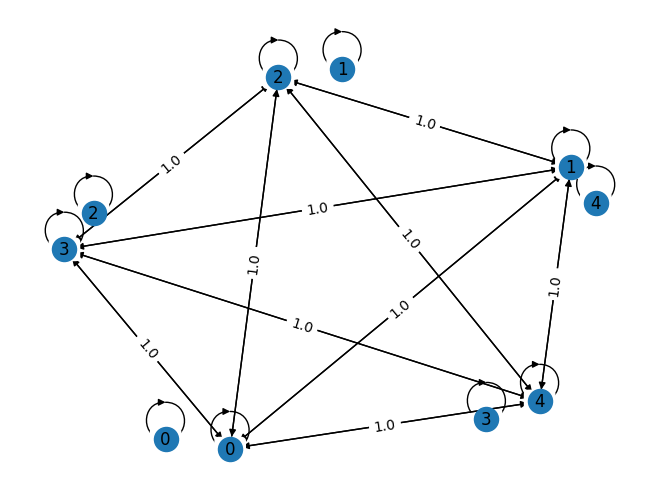

In [20]:
import numpy as np

def visualize(adjacency):
    G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
    nb_nodes = G.number_of_nodes()
    nb_edges = G.number_of_edges()
    print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
    layout = nx.spring_layout(G)
    nx.draw(G, layout)
    nx.draw_networkx_labels(G, layout)        
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

# visualize()
I5 = np.eye(5)
a2 = np.ones([5, 5])
I5, visualize(a2) #  visualize(I5)

**Answer for part 1**

Write here your answer!

**Answer for part 2**

Write here your answer!

**Answer for part 3**

Write here your answer!


### [OPTIONAL] Graph Attention Network (GAT)

While the coefficents in GCN were dependent on both nodes, they were still constant. If we relax this to make them dependent on the current input, we get **attention**. Namely, our update rule for one node will now be:
$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W h_j \right) $$
where $\alpha_{ij}$ are the **attention coefficients**, determining how much of the incoming "message" from node $j$ should node $i$ take in and $\sigma$ is the ELU. 

To compute $\alpha_{ij}$ we apply a one-layer MLP $a$ on concatenated "messages" $Wh_i$ and $Wh_j$ with LeakyReLU activation:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W h_i||W h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}(i)} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W h_i||W h_k\right]\right)\right)}$$

Softmax is applied as normalization, s.t. the sum of coefficients each node uses to receive messages is the same irrespective of the size of the neighborhood.


To stabilize learning, similar to the original Transformer paper, GAT employs **multi-head attention**: each GAT layer has $K$ independent replicas, whose results are simply concatenated to obtain final feature vectors, or averaged if we are at the output layer. Here is a visualization:

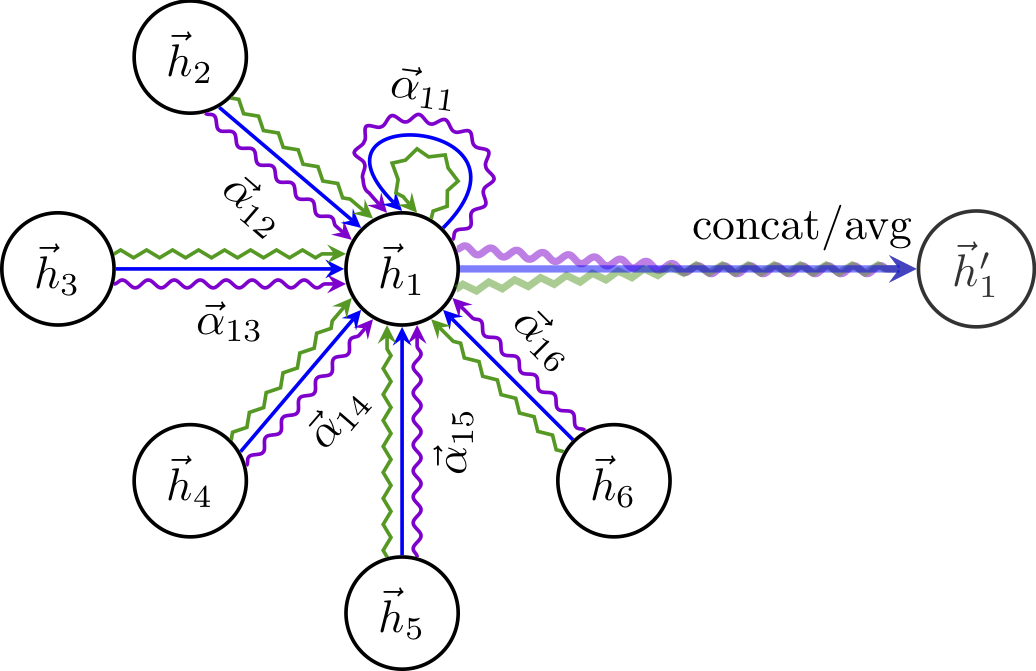

### [OPTIONAL] ***Task 5: Implement GAT***
Let's implement GAT. As the GAT does processing per edge, it is sensible to use the adjacency list representation of graphs instead of the adjecency matrix representation. 

You may want to use the following functions:
- [pytorch_scatter.scatter](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter)
- [torch_geometric.utils.softmax](https://pytorch-geometric.readthedocs.io/en/1.3.2/_modules/torch_geometric/utils/softmax.html)

For example if we have `edge_index` being the adjecency list of shape `[2, num_edges]` and features `fts` of shape `[num_nodes, dims]` then the following code adds the incoming features:
```
u, v = edge_index
edge_fts = fts[u]
agg_fts = torch_scatter.scatter(edge_fts, v, dim=0, reduce='sum')
```

We split the GAT into three modules:
- the `GATAttentionHead` takes in input features, transforms with the linear transformation `W`, computes the attention weights, multiplies the weights with the transformed features and aggregates for each node.
- the `GATLayer` combined multiple attention heads. It can either:
-- Concatenate the outputs (`agg='concat'`)
-- Average the outputs (`agg='mean'`)
- the `GATModel` applies multiple `GATLayers` sequentially and uses the ELU non-linearity between the layers.

You should get at least 79% test accuracy.

In [ ]:
from torch_scatter import scatter
from torch_geometric.utils import softmax as sparse_softmax

class GATAttentionHead(torch.nn.Module):
    def __init__(self, sz_in, sz_out):
        super().__init__()

        ### BEGIN SOLUTION
        
        ### END SOLUTION

    def forward(self, fts, edge_index):
        """
        Args:
            - fts: [num_nodes, sz_in]
            - edge_index: [2, num_edges] list [(u, v)] for edge from u to v

        Return:
            - new_fts: [N, sz_out]

        Hints:
            - Use LeakyReLU with negative slope 0.2 in the attention as per GAT paper.
        """
        ## BEGIN SOLUTION
        return ret_fts
        ### END SOLUTION


class GATLayer(torch.nn.Module):
    def __init__(self, num_heads, sz_in, sz_out, agg):
        super().__init__()

        # Aggregation ('concat', or 'mean' for the last layer)
        self.agg = agg

        ### BEGIN SOLUTION
        ### END SOLUTION

    def forward(self, fts, edge_index):
        """

        Args:
            - fts: [num_nodes, sz_in]
            - edge_index: [2, num_edges] list [(u, v)] for edge from u to v

        Return:
            - new_fts: [N, sz_out * num_head_out]
        
        where num_heads_out = num_heads if agg='concat' else 1 if agg='mean'.
        """
        ### BEGIN SOLUTION
        ### END SOLUTION


class GATModel(torch.nn.Module):
    def __init__(self, num_layers=2, num_heads=8, sz_in=1433, sz_hid=32, sz_out=7):
        super().__init__()

        ### BEGIN SOLUTION
        ### END SOLUTION
    
    def forward(self, fts, edge_index):
        """
        Args:
            - fts: [num_nodes, sz_in]
            - edge_index: [2, num_edges] list [(u, v)] for edge from u to v

        Return:
            - new_fts: [N, sz_out]
        """
        ### BEGIN SOLUTION
        ### END SOLUTION

model = GATModel()
train(model.to(device), data, num_epochs=100, use_edge_index=True)

### Normalizations Galore
Recall that $\mathbf{A}$ is the adjacency matrix and $\mathbf{D}$ is the diagonal matrix of node degrees. In Graph Convolutional Networks (GCNs), it is common to normalize the adjacency as such:

$$\mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2}$$

This is also known as *symmetric normalization* - each term gets normalized by a factor of $\frac{1}{\sqrt{d_i d_j}}$ with $d_i$ denoting the degree of node $i$. 

Another extremely important type of normalization is the following:

$$\mathbf{D}^{-1}\mathbf{A}$$

which is heavily related to Random Walks (RWs) over graphs. Symmetric normalization in practice is the preferred choice as it leads to more interesting dynamics as the normalization depends on both the source and target nodes of the edge.

This all seems like a big soup! We are therefore left with three models:

1.   $\text{GCN}_{RW} = \sigma(\mathbf{D}^{-1}\mathbf{AHW}) $
2.   $\text{GCN} = \sigma(\mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2}\mathbf{HW}) $
3.   $\text{GAT}$ 

Are we able to tie all of these together? 



### Task 6: Relationships between normalizations

Let us show the connection between models 1, 2 and 3. In particular, we have already gone over the difference between 1 and 2, they act as different normalizations of $\mathbf{A}$. Your task(s) are the following:

1.   Compute $\mathbf{D}^{-1}\mathbf{A}$. How can we interpret this resulting matrix as a random walk over a graph?
2.   Write models 1 and 3 in "message-passing" form, ie. show what the computation looks like node-wise for $\mathbf{h}'_i$ - look again at the previous sections for some guidance :) 
3.   Now show that model 1 is a *special case* of GAT! What is the structure of the coefficients? What does this imply in terms of expressive power?



In [ ]:
# Compute D^-1 A for a graph and visualize it 
visualize(...)
# Compute D^-1/2 A D^-1/2 for a graph and visualize it
visualize(...)

**Answer for part 1**

Write here your answer!

**Answer for part 2**

Write here your answer!

**Answer for part 3**

Write here your answer!


## [Part 2] Use PyTorch geometric


Now let's do the same thing using the PyTorch Geometric (PyG) library. 

`torch_geometric.nn` has various GNN layers ready for use, and we can simply plug them in directly instead of our layer classes, and get the same results. The only minor change is that we will set `use_edge_index=True` as `torch_geometric.nn` layers operate directly on the adjacency lists (and take care of preprocessing such as self-loop insertion).

### ***Task 7 (Bonus): Implement GCN in Pytorch Geometric***
Following the example [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.sequential.Sequential) build a model using `torch_geometric.nn.Sequential` and `torch_geometric.nn.GCNConv` to do the CORA node classification task. As before, use two layers, 1433 input dimensions, 32 hidden dimensions and 7 output dimensions.

You should get at least 79% accuracy.

In [ ]:
import torch_geometric.nn as geo_nn

model = geo_nn.Sequential('x, edge_index', [
    (geo_nn.GCNConv(1433, 32), 'x, edge_index -> x'),
    nn.ReLU(inplace=True),
    (geo_nn.GCNConv(32, 7), 'x, edge_index -> x')
])

train(model.to(device), data, num_epochs=100, use_edge_index=True)

However, we only focused on node classification so far, one of 3 common types of problems:

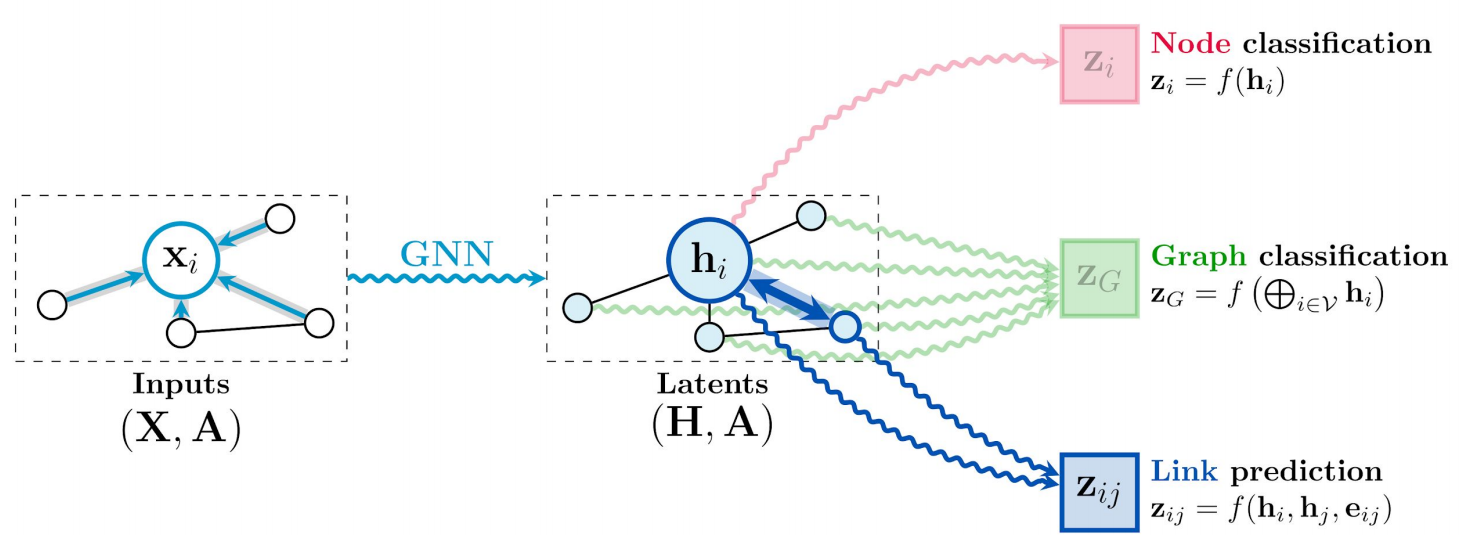

In this part we will also give an example of other two types: **graph classification** and **link prediction**.

### Graph classification with MUTAG

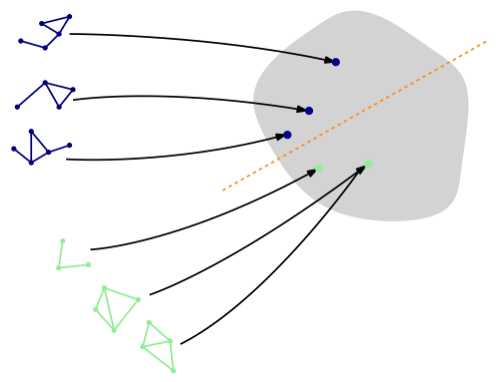

We will demonstrate how to apply GNNs for graph classification. The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one vector, representative of the entire graph, that we use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We will use the **MUTAG** dataset, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection. Let's load and inspect it:

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./', name='MUTAG')

print({dataset})
print(f'Number of graphs: {len(dataset)}') # New!
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()

# Inspect the first graph
print('First graph:')
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set) and plot one of them using networkx.

In [ ]:
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

data = train_dataset[0]

from torch_geometric.utils import to_networkx

# Color the nodes based on the atom type
cmap = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd']
colors = [cmap[torch.argmax(ft)] for ft in data.x]

nx.draw(to_networkx(data), with_labels=True, node_color=colors)

Recall that for node classification we had one graph that we repeatedly forwarded through the network. Now that we have more graphs, it is natural to think about **batching**, to achieve parallelization and speed up the training process. However, our graphs are of different sizes:


In [ ]:
sizes = [data.num_nodes for data in train_dataset]
print(sizes)

To resolve this problem, we would usually (e.g., in images) simply pad the smaller inputs with dummy values such that all inputs end up of the same size, and then group them to form a single batch.

However, for GNNs this is not the most efficient approach. Instead, PyTorch Geometric does the following: 

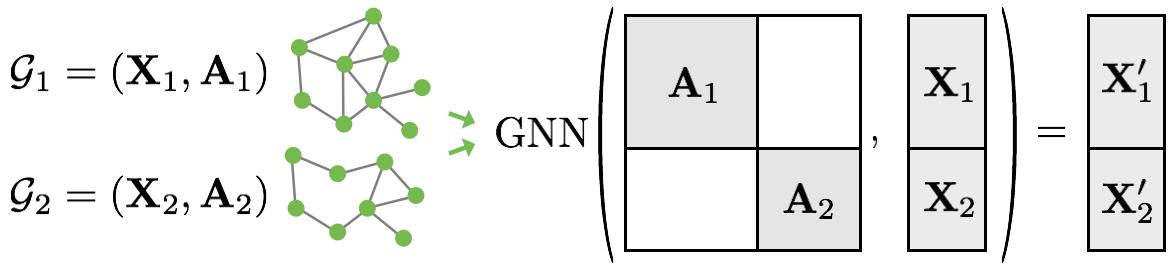

Namely, we stack the adjacency matrix diagonally (i.e., concatenate adjacency lists -- note that this does not waste memory), and simply concatenate node features, to obtain one large graph with several components. It is easy to see that this works with no changes to our network, as adding components this way does not affect the application of GNN on any individual molecule.

PyTorch Geometric conveniently performs this type of batching for us through the `DataLoader` class:

In [ ]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for idx, data in enumerate(train_loader):
    # data is of type 'Batch'
    print(type(data))
    print(f'Batch {idx} size: {data.num_graphs}')

    # apart from edge_index, x, and y, that we would expect
    # a Batch object has a 'batch' property, mapping each node to its component (the original graph)
    # and a 'ptr' property, marking the boundaries between components
    print(data)
    if idx == 2:
        print(data.batch)
        print(data.ptr)
    print()

    # batch is for efficiencies

The model we will use will look very similar to the previously used GNNModel, and we can use any of the previously discussed GNN layers. 

However, once we obtain the final latents for each node, we need a way to **summarize** all latents into one final graph latent ($\bigoplus$ on the above illustration). In other words, we need a **pooling** operation, similar to the one for images. Interestingly, one of the most common approaches in practice is the simple **average pooling**, where the final graph representation is simply the mean of final node representations:
$$ h = \frac{1}{N} \sum_v h_v$$
For this, we use `torch_geometric.nn.global_mean_pool` which will utilize the `batch` property of the Batch object to properly pool individual components and produce one graph embedding vector for each. On this vector, we learn a classifier ($f$ on the above illustration), which is here a simple linear regression.

We adapt the previously used `train` function:

In [ ]:
# Train the given model on the given dataset for num_epochs
def train_graph_classification(model, train_loader, test_loader, num_epochs):
    # Set up the loss and the optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # A utility function to compute the accuracy
    def get_acc(model, loader):
        n_total = 0
        n_ok = 0
        for data in loader:
            data = data.to(device)
            outs = model(data.x, data.edge_index, data.batch).squeeze()
            n_ok += ((outs>0) == data.y).sum().item()
            n_total += data.y.shape[0]
        return n_ok/n_total

    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.to(device)
            # Zero grads -> forward pass -> compute loss -> backprop
            optimizer.zero_grad()
            outs = model(data.x, data.edge_index, data.batch).squeeze()
            loss = loss_fn(outs, data.y.float()) # no train_mask!
            loss.backward()
            optimizer.step()

        # Compute accuracies
        acc_train = get_acc(model, train_loader)
        acc_test = get_acc(model, test_loader)
        print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Train: {acc_train:.3f} | Test: {acc_test:.3f}')

### ***Task 8 (Bonus): Graph Classification***
Build a network of the following architecture:
- GCN channels 7 -> 256
- ReLU
- GCN channels 256 -> 256
- ReLU
- GCN channels 256 -> 256
- ReLU
- Global mean pool
- Linear layer 256 -> 1

As before, follow the example [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.sequential.Sequential).

You should get around 65% test accuracy.

In [ ]:
### BEGIN SOLUTION

### END SOLUTION
print(model)
train_graph_classification(model.to(device), train_loader, test_loader, num_epochs=100)

This concludes the tutorial. I hope you had fun.